# Setup

In this notebook we create a RandomForest bug prediction model based on the preprocessed data.

In [41]:
# imports
import time
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from imblearn.pipeline import make_pipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

In [10]:
# constants
INPUT_DIR = "../../data/input/"
OUTPUT_DIR = "../../data/output/"
FONT_SCALE = 1.3

# configurations
sns.set(font_scale=FONT_SCALE)

# Load data

In [3]:
train = pd.read_csv(OUTPUT_DIR + "train.csv")
test = pd.read_csv(OUTPUT_DIR + "test.csv")

Some data checks

In [4]:
train.head()

,AvgCyclomatic,AvgEssential,CountDeclClassMethodRatio,CountDeclClassVariableRatio,CountDeclInstanceMethodRatio,CountDeclMethodPrivateRatio,CountDeclMethodProtectedRatio,CountDeclMethodPublicRatio,CountLine,CountLineBlankRatio,...,AvgCountClassBase,AvgCountClassCoupled,AvgCountClassDerived,MaxInheritanceTree,AvgPercentLackOfCohesion,AvgCountInput,AvgCountOutput,AvgCountPath,MaxNesting,Bug
0,1.0,1.0,0.00,2.0,1.000000,0.000000,0.000000,1.000000,41.0,0.073171,...,1.000000,2.000000,6.0,1.0,0.000000,7.000000,2.000000,1.000000,0.0,0
1,3.0,2.0,0.25,0.0,0.960000,0.640000,0.000000,0.360000,583.0,0.082333,...,1.333333,35.666667,0.0,2.0,53.666667,4.869565,9.260870,5.391304,3.0,0
2,1.0,1.0,0.00,0.0,1.000000,0.000000,0.333333,0.666667,50.0,0.100000,...,1.000000,4.000000,0.0,3.0,0.000000,0.666667,2.000000,1.333333,1.0,0
3,2.0,1.0,1.00,1.0,0.983051,0.169492,0.000000,0.830508,805.0,0.101863,...,2.000000,58.000000,1.0,1.0,94.000000,3.745763,5.644068,28.288136,6.0,0
4,1.0,1.0,0.00,1.0,1.000000,0.000000,0.000000,1.000000,42.0,0.166667,...,2.000000,2.000000,0.0,4.0,0.000000,1.333333,2.666667,1.000000,0.0,0


<AxesSubplot: xlabel='Bug', ylabel='count'>

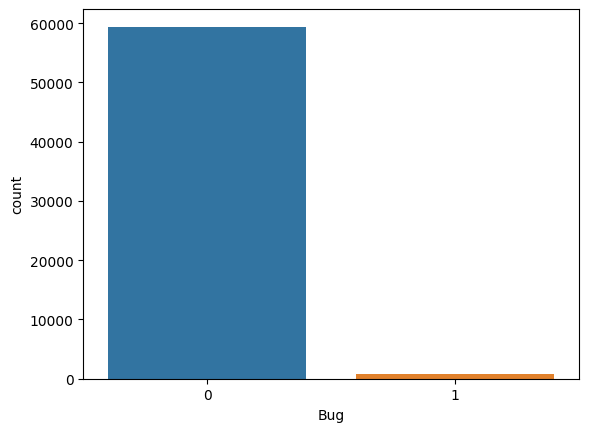

In [7]:
sns.countplot(train, x="Bug")

In [8]:
X_train = train.drop("Bug", axis=1)
y_train = train["Bug"]

X_test = test.drop("Bug", axis=1)
y_test = test["Bug"]

In [9]:
print(y_train.mean())
print(y_test.mean())

0.013255813953488372
0.011694352159468438


# Models

In [31]:
"""Utilities functions."""


def results_headers(): 
  """Returns empty dataframe with correct headers."""
  return pd.DataFrame(columns=['Model', 'ROC-AUC', 'Precision', 'Recall', 'TT (sec)'])


def fit(model, name: str, append_to:pd.DataFrame=results_headers(), X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, plot:bool=True):
  """Fit, evaluate model, and store the results.
  Plot confusion matrix and ROC Curve.
  
  Params
  ======
    model (Any): Sklearn model object.
    name (str): Model name for results.
    append_to (pd.DataFrame): Dataframe to which append the results.
    plot (bool): Plot cm and roc curve if True. Nothing if False.
  """
  # fit and predict model (with timer)
  start_time = time.time()
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  timer = time.time() - start_time

  # get scores
  scores = get_scores(y_test, y_pred)

  if plot is True:
    # plot confusion matrix
    plot_confusion_matrix(y_test, y_pred)
    print("\n")

    # ROC curve and score
    pos_probs = model.predict_proba(X_test)[:,1]
    plot_roc_curve(y_test, pos_probs, scores['ROC-AUC'], name)
    print("\n")

  # store results
  scores = get_scores(y_test, y_pred)
  scores['Model'] = name
  scores['TT (sec)'] = round(timer, 4)
  return append_to.append(scores, ignore_index=True)


def get_scores(y_test, y_pred):
  """Returns a single model scores."""
  return {
    'Model': 'undefined',
    'ROC-AUC': round(metrics.roc_auc_score(y_test, y_pred), 4),
    'Precision': round(metrics.precision_score(y_test, y_pred), 4),
    'Recall': round(metrics.recall_score(y_test, y_pred), 4),
    'TT (sec)': 'NaN'
  }

def plot_confusion_matrix(y_test, y_pred):
  cm = metrics.confusion_matrix(y_test, y_pred)
  # labels components
  titles_ = ['TN', 'FP', 'FN', 'TP']
  counts_ = ["{0:0.0f}".format(val) for val in cm.flatten()]
  pcts_ = ["{0:.0%}".format(val) for val in cm.flatten()/np.sum(cm)]
  # build labels
  labels = [f"{v1}\n{v2}  ({v3})" for v1, v2, v3 in zip(titles_, counts_, pcts_)]
  labels = np.asarray(labels).reshape(2, 2)
  # classes names
  categories = ['0', '1']
  # plot
  fig, ax = plt.subplots(figsize=(8, 6))
  fig.patch.set_facecolor('white')
  sns.set(font_scale=1.5)
  sns.heatmap(pd.DataFrame(cm), annot=labels, cmap="rocket", fmt='', xticklabels=categories, yticklabels=categories)
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  ax.xaxis.set_label_position("top")
  plt.show()
  sns.set(font_scale=FONT_SCALE)


def plot_roc_curve(y_test, pos_probs, roc_auc, title):
  fpr, tpr, thresholds = metrics.roc_curve(y_test, pos_probs)
  # plot
  plt.figure(figsize=(8, 6))
  plt.subplot()
  plt.plot([0, 1], [0, 1], 'k--', label='No skill classifier')
  plt.plot(fpr, tpr, marker='.', label=title)
  plt.xlabel('FP Rate')
  plt.ylabel('TP Rate')
  plt.title(f'{title} - ROC curve')
  plt.annotate(f'AUC = {round(roc_auc, 5)}', xy=(0.7, 0.5), fontsize=12,)
  plt.legend()    
  plt.show()


def plot_feature_importances(model, name, lr=False):
  """Show model features importance."""
  feature_importances = pd.DataFrame(columns = ['features', 'weight'])
  feature_importances['features'] = X_train.columns
  feature_importances['weight'] = (
      model.coef_.reshape(len(feature_importances)) if lr else 
      model.feature_importances_
  )
  feature_importances = feature_importances.sort_values(['weight'], ascending=False)
  # plot
  fig = plt.figure(figsize=(8, 10))
  fig.patch.set_facecolor('white')
  sns.barplot(x='weight', y='features', data=feature_importances, palette="Spectral")
  plt.title(name + ' - Features importance', fontsize = 15)
  plt.show()


def save_model(model, filename):
  """Save a model as pickle."""
  joblib.dump(model, OUTPUT_DIR + f'/models/{filename}.pkl')


def load_model(filename):
  """Load model with name."""
  return joblib.load(OUTPUT_DIR + f'/models/{filename}.pkl')

In [53]:
results = results_headers()

## Random Forest

### Baseline

In [32]:
rf_results = []

In [39]:
# Create params dictionnary
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

params = {
  'n_estimators': n_estimators,
  'max_depth': max_depth,
  'min_samples_split': min_samples_split,
  'min_samples_leaf': min_samples_leaf,
  'bootstrap': bootstrap
}
print(params)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [49]:
rf_baseline = RandomizedSearchCV(RandomForestClassifier(random_state=1), params, scoring='roc_auc', n_iter=5, cv=10, verbose=2, random_state=42, n_jobs=-1)
rf_baseline.fit(X_train, y_train)

print('Best params: ', rf_baseline.best_params_)
print('Best auc: ', round(rf_baseline.best_score_, 4))

Fitting 10 folds for each of 5 candidates, totalling 50 fits
[CV] END bootstrap=True, max_depth=100, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=  32.9s
[CV] END bootstrap=True, max_depth=100, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=  33.0s
[CV] END bootstrap=True, max_depth=100, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=  34.5s
[CV] END bootstrap=True, max_depth=100, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=  35.8s
[CV] END bootstrap=True, max_depth=100, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=  38.9s
[CV] END bootstrap=True, max_depth=100, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=  39.9s
[CV] END bootstrap=True, max_depth=100, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=  43.2s
[CV] END bootstrap=True, max_depth=100, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total 

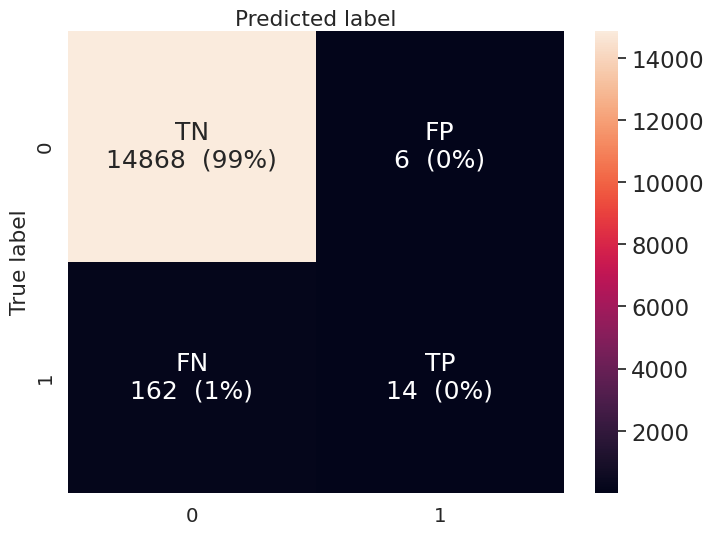

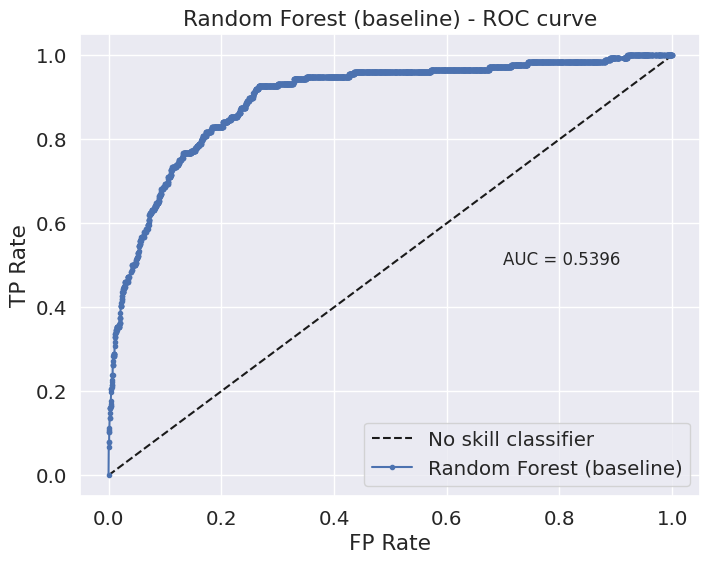

/tmp/ipykernel_16669/4228322487.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return append_to.append(scores, ignore_index=True)


,Model,ROC-AUC,Precision,Recall,TT (sec)
0,Random Forest (baseline),0.5396,0.7,0.0795,59.7577


In [50]:
rf = RandomForestClassifier(random_state=1, n_estimators=1200, min_samples_split=5, min_samples_leaf=1, max_depth=10, bootstrap=False)
rf_pipeline = make_pipeline(rf)
rf_results = fit(rf_pipeline, 'Random Forest (baseline)')
display(rf_results)

### Rebalancing strategies

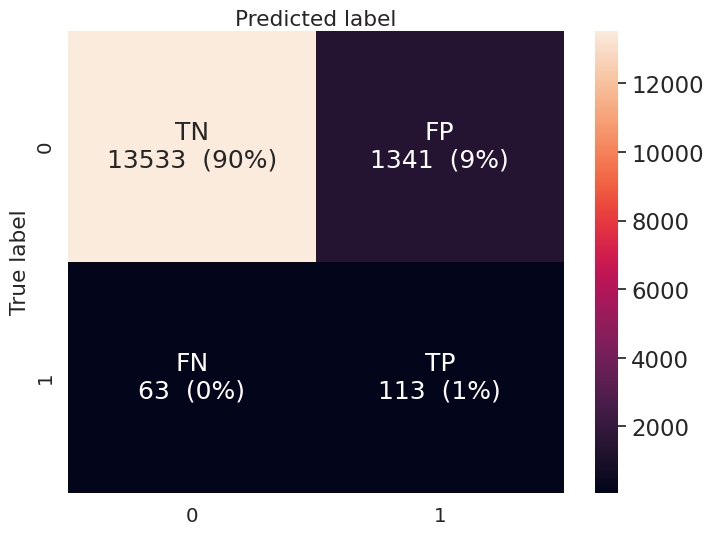

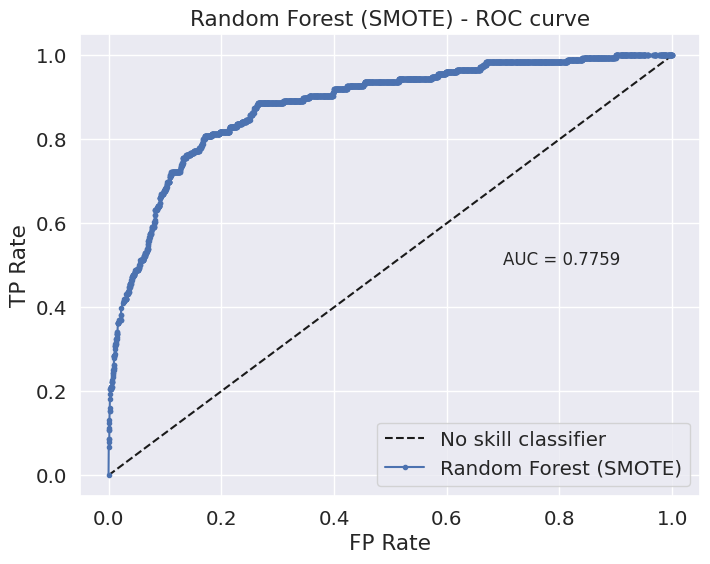

/tmp/ipykernel_16669/4228322487.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return append_to.append(scores, ignore_index=True)


,Model,ROC-AUC,Precision,Recall,TT (sec)
0,Random Forest (baseline),0.5396,0.7000,0.0795,59.7577
1,Random Forest (SMOTE),0.7759,0.0777,0.6420,236.2624


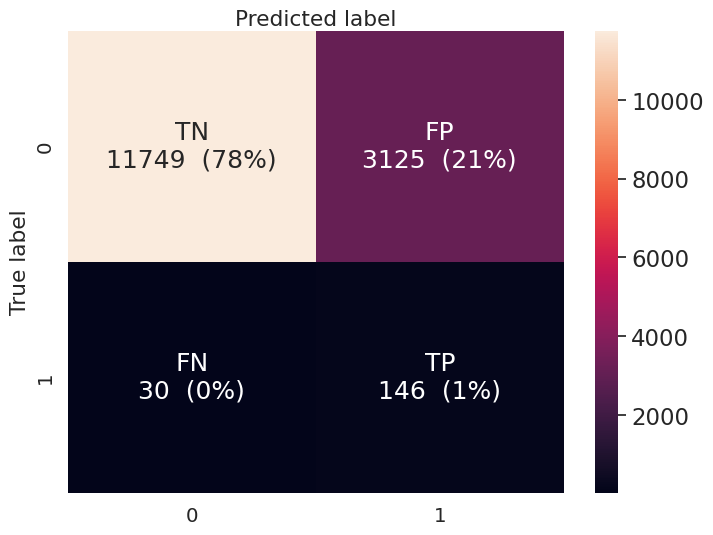

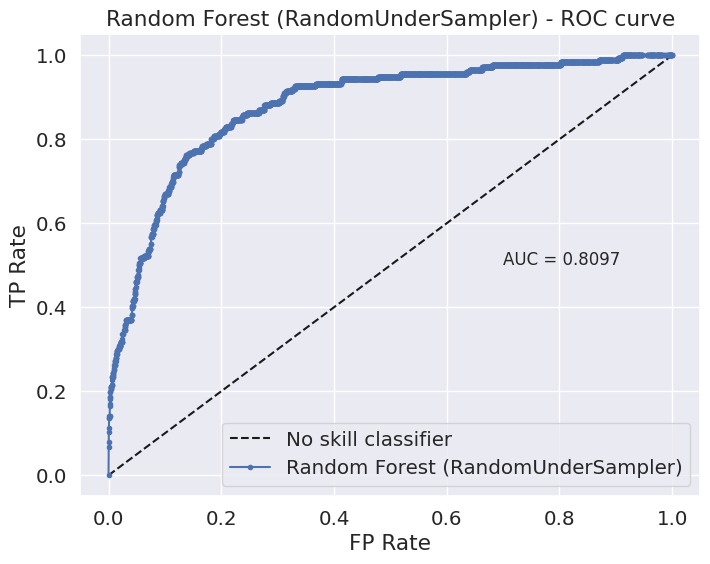

/tmp/ipykernel_16669/4228322487.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return append_to.append(scores, ignore_index=True)


,Model,ROC-AUC,Precision,Recall,TT (sec)
0,Random Forest (baseline),0.5396,0.7000,0.0795,59.7577
1,Random Forest (SMOTE),0.7759,0.0777,0.6420,236.2624
2,Random Forest (RandomUnderSampler),0.8097,0.0446,0.8295,4.7211


In [51]:
for strategy in [SMOTE(random_state=1),
                 RandomUnderSampler(random_state=1, replacement=True)]:
  rf_pipeline = make_pipeline(strategy, rf)
  rf_results = fit(rf_pipeline, f'Random Forest ({strategy.__class__.__name__})', rf_results)
  display(rf_results)

We can see that the RandomUnderSampler performs better on generalisation. We save it and the baseline models

In [52]:
save_model(rf, "rf_baseline")

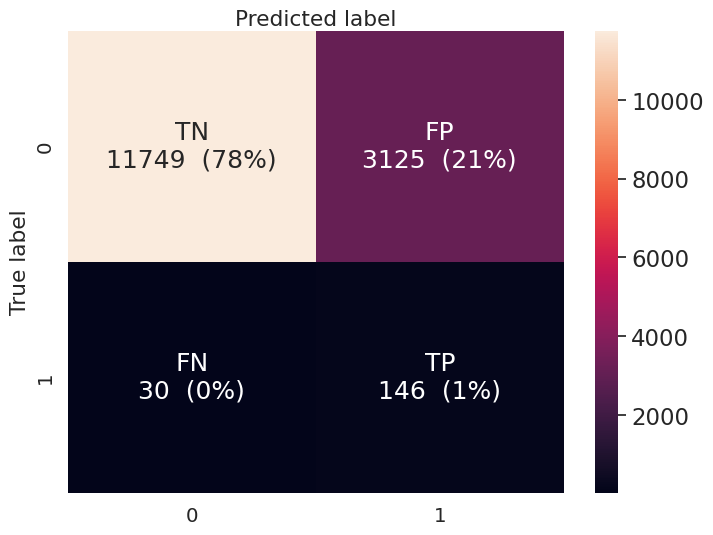

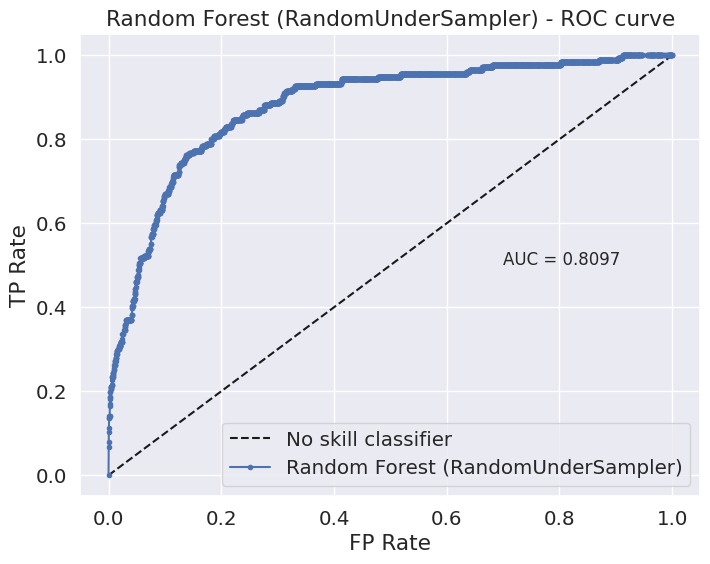

/tmp/ipykernel_16669/4228322487.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return append_to.append(scores, ignore_index=True)


,Model,ROC-AUC,Precision,Recall,TT (sec)
0,Random Forest (RandomUnderSampler),0.8097,0.0446,0.8295,5.6142


In [54]:
rf_pipeline = make_pipeline(
    RandomUnderSampler(random_state=1, replacement=True),
    RandomForestClassifier(random_state=1, n_estimators=1200, min_samples_split=5, min_samples_leaf=1, max_depth=10, bootstrap=False)
)
results = fit(rf_pipeline, f'Random Forest (RandomUnderSampler)', results)
display(results)

In [55]:
save_model(rf_pipeline, "rf_undersampling")